This notebook was written in February 2024 by Roger Romani to show how to generate offset calibration dictionaries, used to calibrate for the nonlinear response of our FEB output. Generally, this shouldn't need to be used much, but is being included in GitHub so a) people can see how it works, and b) any future corrections can be consistently generated.

Note that this calibration only holds for a gain of 50, it would need to be redone at smaller output gains.

In [2]:
import numpy as np
import pandas as pd
from pprint import pprint
import astropy
import vaex as vx
from matplotlib import pyplot as plt
from detanalysis import Analyzer, Semiautocut#, MasterSemiautocuts

import scipy as sp

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from glob import glob
import time as tm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10, 6.5]

import qetpy as qp
import scipy as sp
import pandas as pd
import random
import pickle

from glob import glob
import os
import pytesdaq.io as h5io
import math
from pprint import pprint
import importlib
from inspect import getmembers, isfunction
from copy import copy
import qetpy as qp
import git

from qetpy.core.didv._uncertainties_didv import get_power_noise_with_uncertainties, get_dPdI_with_uncertainties
from qetpy.core.didv._templates_didv import get_simple_energy_normalization, get_energy_normalization
from scipy.fftpack import fft, ifft, fftfreq

from pytesdaq.io.hdf5 import H5Reader
import pytesdaq.io.hdf5 as h5io
h5 = h5io.H5Reader()
import h5py

First, let's load in a bit of data, just to get the metadata for a typical event.

In [3]:
path_1 = '/sdata1/runs/run38/raw/continuous_I2_D20240219_T151122/cont_I2_D20240219_T151148_F0001.hdf5'

chans = ['CPDv2Al2O3']

h5read = H5Reader()
traces, metadata = h5read.read_many_events(
    filepath = path_1,
    nevents=-1, #this tells read_many_events to read all the events in the file
    output_format=2,
    #detector_chans=chans,
    include_metadata=True, #we want the metadata to look at e.g. the device bias current
    adctoamp = True
)

print(metadata[0]['detector_chans'])

['NoDeviceA', 'NoDeviceB', 'NoDeviceD', 'CPDv21Al2O3']


We'd like to extract the close loop norm and the output gain from the metadata.

In [5]:
print(metadata[0].keys())
print(" ")
print(metadata[0]['detector_config']['NoDeviceA'].keys())
print(" ")
print(metadata[0]['detector_config']['NoDeviceA']['close_loop_norm'])
print(" ")

output_gain = metadata[0]['detector_config']['NoDeviceA']['output_gain']
close_loop_norm = metadata[0]['detector_config']['NoDeviceA']['close_loop_norm']

dict_keys(['event_id', 'event_index', 'event_num', 'event_time', 'comment', 'daq_version', 'data_purpose', 'data_type', 'dump_num', 'facility', 'format_version', 'fridge_run', 'fridge_run_start', 'group_comment', 'group_name', 'group_start', 'prefix', 'run_purpose', 'run_type', 'series_num', 'series_start', 'timestamp', 'adc_channel_indices', 'adc_conversion_factor', 'connection0', 'connection1', 'connection2', 'connection3', 'data_mode', 'nb_channels', 'nb_events', 'nb_samples', 'sample_rate', 'voltage_range', 'read_status', 'error_msg', 'adc_chans', 'detector_chans', 'tes_chans', 'controller_chans', 'detector_config'])
 
dict_keys(['adc_channel_indices', 'adc_conversion_factor', 'adc_name', 'channel_list', 'channel_type', 'close_loop_norm', 'feedback_mode', 'feedback_polarity', 'feedback_resistance', 'lock_point_voltage', 'open_loop_full_norm', 'open_loop_preamp_norm', 'output_gain', 'output_offset', 'preamp_gain', 'shunt_resistance', 'signal_gen_current', 'signal_gen_frequency', 'si

Now, let's load in data that we'll use to make out calibration out of. This is generated using a script Bruno wrote, which is on the DAQ computer in the /data/daq/tests/ folder.

In [6]:
with open('/sdata1/runs/run38/linearity_1a.pickle', 'rb') as handle:
    linearity_data = pickle.load(handle)

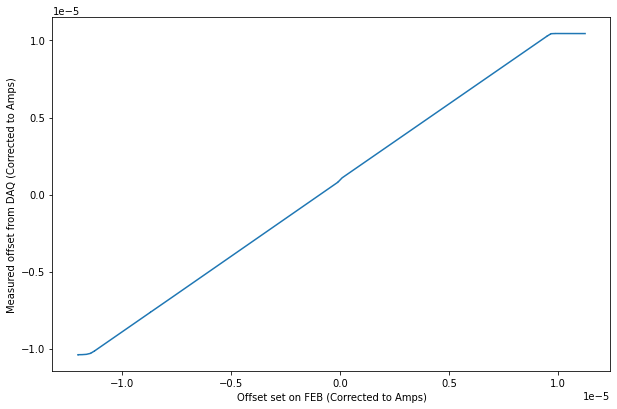

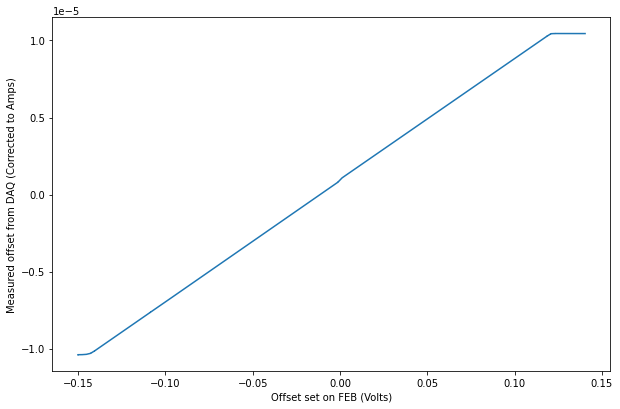

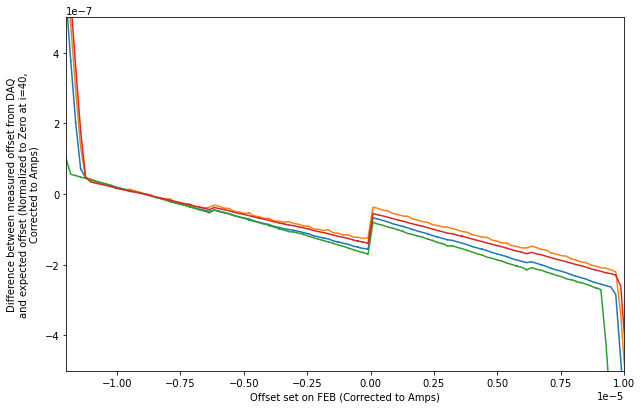

In [12]:
#"offset"s are the numbers we put in from the FEB
#"measured"s are the voltages we read in from the DAQ, i.e. the output from the FEB.
offset_v_a = linearity_data['A']['variable_offset_V']
measured_v_a = linearity_data['A']['measure_offset_V']

offset_v_b = linearity_data['B']['variable_offset_V']
measured_v_b = linearity_data['B']['measure_offset_V']

offset_v_c = linearity_data['C']['variable_offset_V']
measured_v_c = linearity_data['C']['measure_offset_V']

offset_v_d = linearity_data['D']['variable_offset_V']
measured_v_d = linearity_data['D']['measure_offset_V']

#we can scale this to approximate current units (i.e. a current we'd reconstruct from the SQUID) by multiplying
#by the output gain (i.e. 50) and dividing by the close loop norm.

plt.plot(np.asarray(offset_v_a) * output_gain/ close_loop_norm, measured_v_a / close_loop_norm, marker = '')
plt.xlabel("Offset set on FEB (Corrected to Amps)")
plt.ylabel("Measured offset from DAQ (Corrected to Amps)")
plt.show()

plt.plot(np.asarray(offset_v_a), measured_v_a / close_loop_norm, marker = '')
plt.xlabel("Offset set on FEB (Volts)")
plt.ylabel("Measured offset from DAQ (Corrected to Amps)")
plt.show()

zero_val_a = (measured_v_a / close_loop_norm - np.asarray(offset_v_a) * output_gain/ close_loop_norm)[40]
zero_val_b = (measured_v_b / close_loop_norm - np.asarray(offset_v_b) * output_gain/ close_loop_norm)[40]
zero_val_c = (measured_v_c / close_loop_norm - np.asarray(offset_v_c) * output_gain/ close_loop_norm)[40]
zero_val_d = (measured_v_d / close_loop_norm - np.asarray(offset_v_d) * output_gain/ close_loop_norm)[40]

plt.plot(np.asarray(offset_v_a) * output_gain/ close_loop_norm,
         measured_v_a / close_loop_norm - np.asarray(offset_v_a) * output_gain/ close_loop_norm - zero_val_a,
         marker = '')
plt.plot(np.asarray(offset_v_b) * output_gain/ close_loop_norm,
         measured_v_b / close_loop_norm - np.asarray(offset_v_b) * output_gain/ close_loop_norm - zero_val_b,
         marker = '')
plt.plot(np.asarray(offset_v_c) * output_gain/ close_loop_norm,
         measured_v_c / close_loop_norm - np.asarray(offset_v_c) * output_gain/ close_loop_norm - zero_val_c,
         marker = '')
plt.plot(np.asarray(offset_v_d) * output_gain/ close_loop_norm,
         measured_v_d / close_loop_norm - np.asarray(offset_v_d) * output_gain/ close_loop_norm - zero_val_d,
         marker = '')
plt.ylim(-0.5e-6, 0.5e-6)
plt.xlim(-1.2e-5, 1.0e-5)
plt.xlabel("Offset set on FEB (Corrected to Amps)")
plt.ylabel("Difference between measured offset from DAQ\nand expected offset (Normalized to Zero at i=40,\nCorrected to Amps)")
plt.show()

In [14]:
current_measured_a = measured_v_a / close_loop_norm
current_measured_b = measured_v_b / close_loop_norm
current_measured_c = measured_v_c / close_loop_norm
current_measured_d = measured_v_d / close_loop_norm

In [15]:
offset_v_a = np.asarray(offset_v_a)
offset_v_b = np.asarray(offset_v_b)
offset_v_c = np.asarray(offset_v_c)
offset_v_d = np.asarray(offset_v_d)

Now, we can extrapolate beyond the ranges we were explicitly able to calibrate by fitting a line. To do this, we'll define regions at high and low offsets where the response is linear, and fit lines to this.

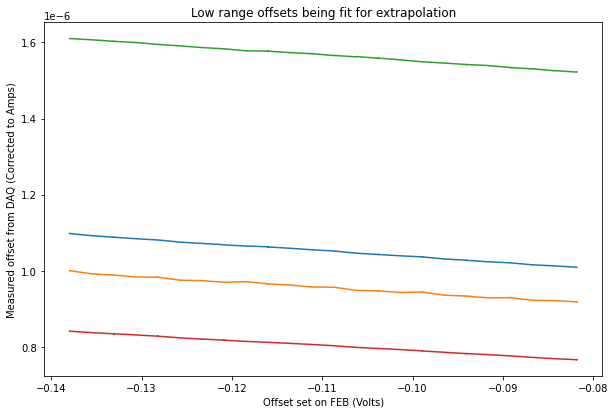

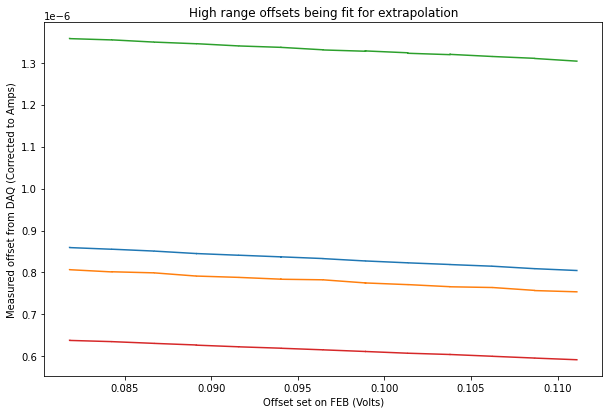

In [16]:
#These are the indices of low range offsets that we'll extrapolate from
lim_low_m = 12
lim_low_p = 70

plt.plot(offset_v_a[lim_low_m:lim_low_p],
         current_measured_a[lim_low_m:lim_low_p] - np.asarray(offset_v_a[lim_low_m:lim_low_p])*output_gain/close_loop_norm)
plt.plot(offset_v_b[lim_low_m:lim_low_p],
         current_measured_b[lim_low_m:lim_low_p] - np.asarray(offset_v_b[lim_low_m:lim_low_p])*output_gain/close_loop_norm)
plt.plot(offset_v_c[lim_low_m:lim_low_p],
         current_measured_c[lim_low_m:lim_low_p] - np.asarray(offset_v_c[lim_low_m:lim_low_p])*output_gain/close_loop_norm)
plt.plot(offset_v_d[lim_low_m:lim_low_p],
         current_measured_d[lim_low_m:lim_low_p] - np.asarray(offset_v_a[lim_low_m:lim_low_p])*output_gain/close_loop_norm)
plt.title("Low range offsets being fit for extrapolation")
plt.xlabel("Offset set on FEB (Volts)")
plt.ylabel("Measured offset from DAQ (Corrected to Amps)")
plt.show()

lim_high_m = -60
lim_high_p = -30

plt.plot(offset_v_a[lim_high_m:lim_high_p],
         current_measured_a[lim_high_m:lim_high_p] - np.asarray(offset_v_a[lim_high_m:lim_high_p])*output_gain/close_loop_norm)
plt.plot(offset_v_b[lim_high_m:lim_high_p],
         current_measured_b[lim_high_m:lim_high_p] - np.asarray(offset_v_b[lim_high_m:lim_high_p])*output_gain/close_loop_norm)
plt.plot(offset_v_c[lim_high_m:lim_high_p],
         current_measured_c[lim_high_m:lim_high_p] - np.asarray(offset_v_c[lim_high_m:lim_high_p])*output_gain/close_loop_norm)
plt.plot(offset_v_d[lim_high_m:lim_high_p],
         current_measured_d[lim_high_m:lim_high_p] - np.asarray(offset_v_a[lim_high_m:lim_high_p])*output_gain/close_loop_norm)
plt.title("High range offsets being fit for extrapolation")
plt.xlabel("Offset set on FEB (Volts)")
plt.ylabel("Measured offset from DAQ (Corrected to Amps)")
plt.show()

Now, we'll do these fits and record the best fit parameters and covariance matrix.

In [17]:
def linear(x, m, b):
    return x*m + b

guess = [1e-5, 1e-7]

result_a_low, pcov_a_low = sp.optimize.curve_fit(linear,
                                                 offset_v_a[lim_low_m:lim_low_p],
                                                 current_measured_a[lim_low_m:lim_low_p], p0=guess)
result_b_low, pcov_b_low = sp.optimize.curve_fit(linear,
                                                 offset_v_b[lim_low_m:lim_low_p],
                                                 current_measured_b[lim_low_m:lim_low_p], p0=guess)
result_c_low, pcov_c_low = sp.optimize.curve_fit(linear,
                                                 offset_v_c[lim_low_m:lim_low_p],
                                                 current_measured_c[lim_low_m:lim_low_p], p0=guess)
result_d_low, pcov_d_low = sp.optimize.curve_fit(linear,
                                                 offset_v_d[lim_low_m:lim_low_p],
                                                 current_measured_d[lim_low_m:lim_low_p], p0=guess)

result_a_high, pcov_a_high = sp.optimize.curve_fit(linear, offset_v_a[lim_high_m:lim_high_p],
                                                   current_measured_a[lim_high_m:lim_high_p], p0=guess)
result_b_high, pcov_b_high = sp.optimize.curve_fit(linear, offset_v_b[lim_high_m:lim_high_p],
                                                   current_measured_b[lim_high_m:lim_high_p], p0=guess)
result_c_high, pcov_c_high = sp.optimize.curve_fit(linear, offset_v_c[lim_high_m:lim_high_p],
                                                   current_measured_c[lim_high_m:lim_high_p], p0=guess)
result_d_high, pcov_d_high = sp.optimize.curve_fit(linear, offset_v_d[lim_high_m:lim_high_p],
                                                   current_measured_d[lim_high_m:lim_high_p], p0=guess)

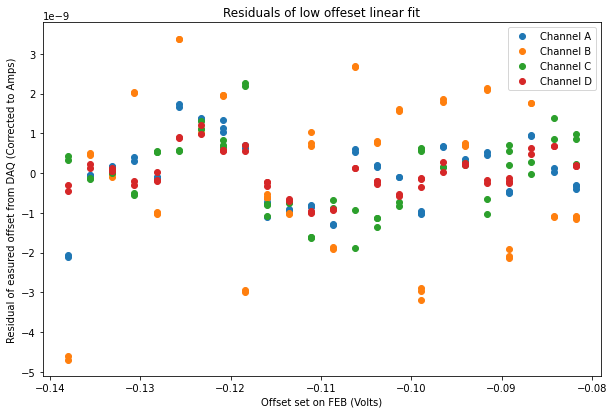

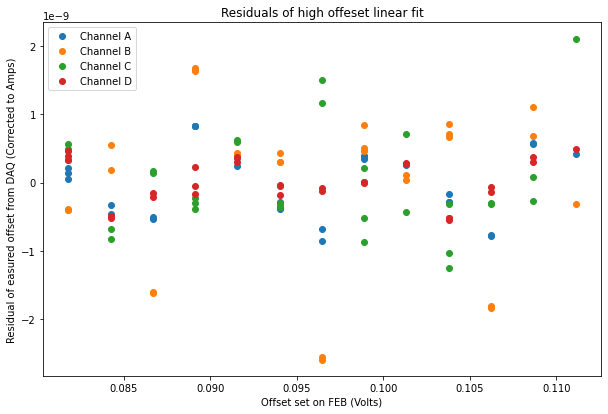

In [18]:
resids_a_low = linear(offset_v_a[lim_low_m:lim_low_p], *result_a_low) - current_measured_a[lim_low_m:lim_low_p]
resids_b_low = linear(offset_v_b[lim_low_m:lim_low_p], *result_b_low) - current_measured_b[lim_low_m:lim_low_p]
resids_c_low = linear(offset_v_c[lim_low_m:lim_low_p], *result_c_low) - current_measured_c[lim_low_m:lim_low_p]
resids_d_low = linear(offset_v_d[lim_low_m:lim_low_p], *result_d_low) - current_measured_d[lim_low_m:lim_low_p]

resids_a_high = linear(offset_v_a[lim_high_m:lim_high_p], *result_a_high) - current_measured_a[lim_high_m:lim_high_p]
resids_b_high = linear(offset_v_b[lim_high_m:lim_high_p], *result_b_high) - current_measured_b[lim_high_m:lim_high_p]
resids_c_high = linear(offset_v_c[lim_high_m:lim_high_p], *result_c_high) - current_measured_c[lim_high_m:lim_high_p]
resids_d_high = linear(offset_v_d[lim_high_m:lim_high_p], *result_d_high) - current_measured_d[lim_high_m:lim_high_p]


plt.plot(offset_v_a[lim_low_m:lim_low_p], resids_a_low, marker = 'o', linestyle = 'none', label = "Channel A")
plt.plot(offset_v_b[lim_low_m:lim_low_p], resids_b_low, marker = 'o', linestyle = 'none', label = "Channel B")
plt.plot(offset_v_c[lim_low_m:lim_low_p], resids_c_low, marker = 'o', linestyle = 'none', label = "Channel C")
plt.plot(offset_v_d[lim_low_m:lim_low_p], resids_d_low, marker = 'o', linestyle = 'none', label = "Channel D")
plt.title("Residuals of low offeset linear fit")
plt.xlabel("Offset set on FEB (Volts)")
plt.ylabel("Residual of easured offset from DAQ (Corrected to Amps)")
plt.legend()
plt.show()


plt.plot(offset_v_a[lim_high_m:lim_high_p], resids_a_high, marker = 'o', linestyle = 'none', label = "Channel A")
plt.plot(offset_v_b[lim_high_m:lim_high_p], resids_b_high, marker = 'o', linestyle = 'none', label = "Channel B")
plt.plot(offset_v_c[lim_high_m:lim_high_p], resids_c_high, marker = 'o', linestyle = 'none', label = "Channel C")
plt.plot(offset_v_d[lim_high_m:lim_high_p], resids_d_high, marker = 'o', linestyle = 'none', label = "Channel D")
plt.legend()
plt.title("Residuals of high offeset linear fit")
plt.xlabel("Offset set on FEB (Volts)")
plt.ylabel("Residual of easured offset from DAQ (Corrected to Amps)")
plt.show()

There seems to be some systematic low and high points, but it's clearly way better than the uncalibrated approximation before.

Untimately, what we want is a lookup table for every offset we were able to calibrate, with extrapolations above and below. In the above cells, we calculated the extrapolation, now it's time to make the lookup table.

This is slightly nontrivial because we have multiple measurements at every offset value we can actually output from the FEB. We'll therefore average these together to get a single correction value to look up for every calibrated FEB offset.

Number of total points: 291
Number of unique points: 120


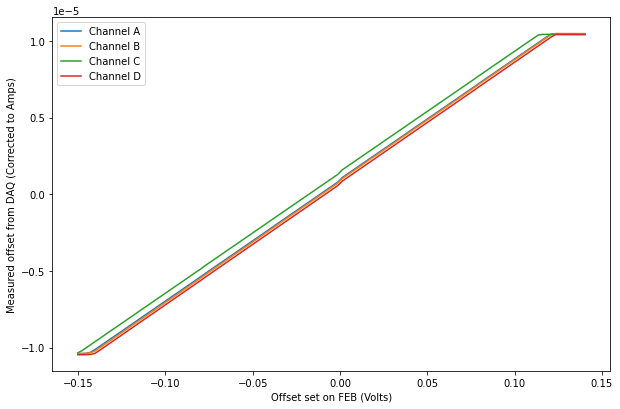

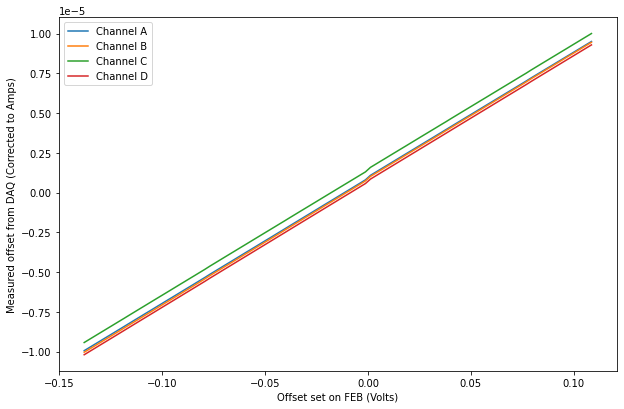

In [21]:
offsets_a_unique = np.unique(offset_v_a)
offsets_b_unique = np.unique(offset_v_b)
offsets_c_unique = np.unique(offset_v_c)
offsets_d_unique = np.unique(offset_v_d)

print("Number of total points: " + str(len(offset_v_a)))
print("Number of unique points: " + str(len(offsets_a_unique)))

currents_a_unique = np.zeros_like(offsets_a_unique)
currents_b_unique = np.zeros_like(offsets_b_unique)
currents_c_unique = np.zeros_like(offsets_c_unique)
currents_d_unique = np.zeros_like(offsets_d_unique)

i = 0
while i < len(offsets_a_unique):
    
    sum_a = 0.0
    indices_a = [k for k, e in enumerate(offset_v_a) if e == offsets_a_unique[i]]
    j = 0
    while j < len(indices_a):
        sum_a += current_measured_a[indices_a[j]]
        j += 1
    average_a = sum_a/len(indices_a)
    currents_a_unique[i] = average_a
    
    i += 1
    
i = 0
while i < len(offsets_a_unique):
    
    sum_b = 0.0
    indices_b = [k for k, e in enumerate(offset_v_b) if e == offsets_b_unique[i]]
    j = 0
    while j < len(indices_b):
        sum_b += current_measured_b[indices_b[j]]
        j += 1
    average_b = sum_b/len(indices_b)
    currents_b_unique[i] = average_b
    
    i += 1
    
i = 0
while i < len(offsets_c_unique):
    
    sum_c = 0.0
    indices_c = [k for k, e in enumerate(offset_v_c) if e == offsets_c_unique[i]]
    j = 0
    while j < len(indices_c):
        sum_c += current_measured_c[indices_c[j]]
        j += 1
    average_c = sum_c/len(indices_c)
    currents_c_unique[i] = average_c
    
    i += 1
    
i = 0
while i < len(offsets_d_unique):
    
    sum_d = 0.0
    indices_d = [k for k, e in enumerate(offset_v_d) if e == offsets_d_unique[i]]
    j = 0
    while j < len(indices_d):
        sum_d += current_measured_d[indices_d[j]]
        j += 1
    average_d = sum_d/len(indices_d)
    currents_d_unique[i] = average_d
    
    i += 1
    
lim_low = list(offsets_a_unique).index(offset_v_a[lim_low_m])
lim_high = list(offsets_a_unique).index(offset_v_a[lim_high_p])
    
plt.plot(offsets_a_unique, currents_a_unique, label = "Channel A")
plt.plot(offsets_b_unique, currents_b_unique, label = "Channel B")
plt.plot(offsets_c_unique, currents_c_unique, label = "Channel C")
plt.plot(offsets_d_unique, currents_d_unique, label = "Channel D")
plt.xlabel("Offset set on FEB (Volts)")
plt.ylabel("Measured offset from DAQ (Corrected to Amps)")
plt.legend()
plt.show()
    
plt.plot(offsets_a_unique[lim_low:lim_high], currents_a_unique[lim_low:lim_high], label = "Channel A")
plt.plot(offsets_b_unique[lim_low:lim_high], currents_b_unique[lim_low:lim_high], label = "Channel B")
plt.plot(offsets_c_unique[lim_low:lim_high], currents_c_unique[lim_low:lim_high], label = "Channel C")
plt.plot(offsets_d_unique[lim_low:lim_high], currents_d_unique[lim_low:lim_high], label = "Channel D")
plt.xlabel("Offset set on FEB (Volts)")
plt.ylabel("Measured offset from DAQ (Corrected to Amps)")
plt.legend()
plt.show()

[-0.19       -0.18       -0.17       -0.16       -0.15       -0.15018315
 -0.14774115 -0.14529915 -0.14285714 -0.14041514 -0.13797314 -0.13553114
 -0.13308913 -0.13064713 -0.12820513 -0.12576313 -0.12332112 -0.12087912
 -0.11843712 -0.11599512 -0.11355311 -0.11111111 -0.10866911 -0.10622711
 -0.1037851  -0.1013431  -0.0989011  -0.0964591  -0.09401709 -0.09157509
 -0.08913309 -0.08669109 -0.08424908 -0.08180708 -0.07936508 -0.07692308
 -0.07448107 -0.07203907 -0.06959707 -0.06715507 -0.06471306 -0.06227106
 -0.05982906 -0.05738706 -0.05494505 -0.05250305 -0.05006105 -0.04761905
 -0.04517705 -0.04273504 -0.04029304 -0.03785104 -0.03540904 -0.03296703
 -0.03052503 -0.02808303 -0.02564103 -0.02319902 -0.02075702 -0.01831502
 -0.01587302 -0.01343101 -0.01098901 -0.00854701 -0.00610501 -0.003663
 -0.001221    0.001221    0.003663    0.00610501  0.00854701  0.01098901
  0.01343101  0.01587302  0.01831502  0.02075702  0.02319902  0.02564103
  0.02808303  0.03052503  0.03296703  0.03540904  0.0

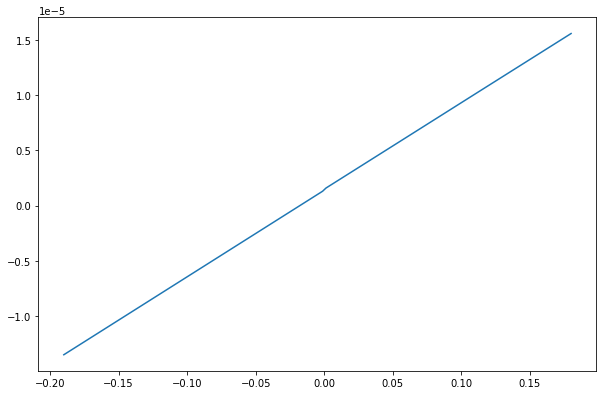

In [23]:
def get_calibrated_offset(offset, offsets_arr, currents_arr, params_low, params_high):
    def linear(x, m, b):
        return x*m + b
    
    if offset in offsets_arr:
        return currents_arr[list(offsets_arr).index(offset)]
    elif offset > 0.0:
        return linear(offset, *params_high)
    else:
        return linear(offset, *params_low)
    
cal_offsets_test_arr = np.zeros(len(offsets_a_unique) + 10)
cal_offsets_test_arr[0:5] = np.arange(-0.19, -0.14, 0.01)
cal_offsets_test_arr[5:-5] = offsets_b_unique
cal_offsets_test_arr[-5:] = np.arange(0.14, 0.19, 0.01)
print(cal_offsets_test_arr)

#this is a test, just to demonstrate that we return unique 
calibrated_currents_test = np.zeros_like(cal_offsets_test_arr)
i = 0
while i < len(cal_offsets_test_arr):
    calibrated_currents_test[i] = get_calibrated_offset(cal_offsets_test_arr[i],
                                                       offsets_c_unique[lim_low:lim_high],
                                                        currents_c_unique[lim_low:lim_high],
                                                       result_c_low, result_c_high)
    i += 1
    
#this is a test plot
plt.plot(cal_offsets_test_arr, calibrated_currents_test)
plt.show()

In [109]:
calibration_dict_a = {'model': 'lookup_extrapolated', 
                     'params': {'params_low': result_a_low, 
                                'params_high': result_a_high,
                                'lookup_x': offsets_a_unique[lim_low:lim_high],
                                'lookup_y': currents_a_unique[lim_low:lim_high]
                               },
                     'cov': {'cov_low': pcov_a_low,
                            'cov_high': pcov_a_high},
                     'channel': 'A'}

calibration_dict_b = {'model': 'lookup_extrapolated', 
                     'params': {'params_low': result_b_low, 
                                'params_high': result_b_high,
                                'lookup_x': offsets_b_unique[lim_low:lim_high],
                                'lookup_y': currents_b_unique[lim_low:lim_high]
                               },
                     'cov': {'cov_low': pcov_b_low,
                            'cov_high': pcov_b_high},
                     'channel': 'B'}

calibration_dict_c = {'model': 'lookup_extrapolated', 
                     'params': {'params_low': result_c_low, 
                                'params_high': result_c_high,
                                'lookup_x': offsets_c_unique[lim_low:lim_high],
                                'lookup_y': currents_c_unique[lim_low:lim_high]
                               },
                     'cov': {'cov_low': pcov_c_low,
                            'cov_high': pcov_c_high},
                     'channel': 'C'}

calibration_dict_d = {'model': 'lookup_extrapolated', 
                     'params': {'params_low': result_d_low, 
                                'params_high': result_d_high,
                                'lookup_x': offsets_d_unique[lim_low:lim_high],
                                'lookup_y': currents_d_unique[lim_low:lim_high]
                               },
                     'cov': {'cov_low': pcov_d_low,
                            'cov_high': pcov_d_high},
                     'channel': 'D'}

In [88]:
print(metadata_arr[0][0].keys())
print(" ")
print(metadata_arr[0][0]['detector_config'].keys())
print(" ")
print(metadata_arr[0][0]['detector_config']['NoDeviceA'].keys())
print(" ")
print(metadata_arr[0][0]['detector_config']['NoDeviceA']['output_offset'])

output_gain = metadata_arr[0][0]['detector_config']['NoDeviceA']['output_gain']
close_loop_norm = metadata_arr[0][0]['detector_config']['NoDeviceA']['close_loop_norm']

dict_keys(['event_id', 'event_index', 'event_num', 'event_time', 'comment', 'daq_version', 'data_purpose', 'data_type', 'dump_num', 'facility', 'format_version', 'fridge_run', 'fridge_run_start', 'group_comment', 'group_name', 'group_start', 'prefix', 'run_purpose', 'run_type', 'series_num', 'series_start', 'timestamp', 'adc_channel_indices', 'adc_conversion_factor', 'connection0', 'connection1', 'connection2', 'connection3', 'data_mode', 'nb_channels', 'nb_events', 'nb_samples', 'sample_rate', 'voltage_range', 'read_status', 'error_msg', 'adc_chans', 'detector_chans', 'tes_chans', 'controller_chans', 'detector_config'])
 
dict_keys(['NoDeviceA', 'NoDeviceB', 'NoDeviceD', 'CPDv21Al2O3'])
 
dict_keys(['adc_channel_indices', 'adc_conversion_factor', 'adc_name', 'channel_list', 'channel_type', 'close_loop_norm', 'feedback_mode', 'feedback_polarity', 'feedback_resistance', 'lock_point_voltage', 'open_loop_full_norm', 'open_loop_preamp_norm', 'output_gain', 'output_offset', 'preamp_gain', '

In [110]:
with open('offset_cal_dict_a_022124.pickle', 'wb') as handle:
    pickle.dump(calibration_dict_a, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('offset_cal_dict_b_022124.pickle', 'wb') as handle:
    pickle.dump(calibration_dict_b, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('offset_cal_dict_c_022124.pickle', 'wb') as handle:
    pickle.dump(calibration_dict_c, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('offset_cal_dict_d_022124.pickle', 'wb') as handle:
    pickle.dump(calibration_dict_d, handle, protocol=pickle.HIGHEST_PROTOCOL)